## Ukrainian automotive market 2013-2019 (tentative title)
<hr>

Data is publically accessible at [Ukrainian Open Data Portal](https://data.gov.ua)

Anonymized annual datasets of [vehicle owners](https://data.gov.ua/en/dataset/06779371-308f-42d7-895e-5a39833375f0) for the period from 01-January-2013 till 12-October-2019 was used in analysis.

### Ideas for use of data:

- Article analyzing market trends for 7 years
- Create publically accessible dashboard
- Interactive chart to analyze data in time

### Data export from CSV-files

In [1]:
import pandas as pd
import numpy as np
%timeit

In [2]:
files = []
# files = !ls -d "$PWD"/datasets/* | grep tz_opendata # Absolute path
files = !ls -d ./datasets/* | grep tz_opendata # relative path
files

['./datasets/tz_opendata_z01012013_po31122013.csv',
 './datasets/tz_opendata_z01012014_po31122014.csv',
 './datasets/tz_opendata_z01012015_po31122015.csv',
 './datasets/tz_opendata_z01012016_po31122016.csv',
 './datasets/tz_opendata_z01012017_po31122017.csv',
 './datasets/tz_opendata_z01012018_po01012019.csv']

In [ ]:
#    This Cell normally can be skipped.
#    It was used for TEST of the 2019 dataset having some incorrect data. 


#map_cols_dtypes = {'own_weight': np.float64,
#                   'OWN_WEIGHT': np.float64,
#                   'total_weight':np.float64,
#                   'TOTAL_WEIGHT':np.float64,
#                   'n_reg_new': object
#                  }

#df_ = pd.read_csv(files[6], sep=';', 
#                      parse_dates=['d_reg'], 
#                      index_col='d_reg', 
#                      low_memory=False,
#                      dtype=map_cols_dtypes,
#                      error_bad_lines=False,
#                     )



In [ ]:
# %timeit -r1 df = pd.read_csv(files[0], sep=';', parse_dates=['d_reg'], index_col='d_reg', low_memory=False)
# df = pd.read_csv(files[6], sep=';', parse_dates=['d_reg'], index_col='d_reg', low_memory=False)

In [3]:
'''
    Export data from 7 annual csv-files into one merged dataset.
    
    Original 2019 csv-file data cleaned manually before export. 
    Removed "," used as decimal separator in several columns.
'''

df = pd.DataFrame()

map_cols_dtypes = {'own_weight': np.float64,
                   'OWN_WEIGHT': np.float64,
                   'total_weight': np.float64,
                   'TOTAL_WEIGHT': np.float64,
                   'n_reg_new': object
                  }

for i, file in enumerate(files):
    df_ = pd.read_csv(file, sep=';', 
                      parse_dates=['d_reg'], 
                      index_col='d_reg',
                      skipinitialspace=True,
                      dtype=map_cols_dtypes,
                      error_bad_lines=False,
                     )
    
    df_.rename(str.capitalize, axis='columns', inplace=True)
    df = df.append(df_).sort_index()
    print("Finished loop {} of {} for file: {}".format(i+1, len(files), file))
    
print("All done!")

Finished loop 1 of 6 for file: ./datasets/tz_opendata_z01012013_po31122013.csv
Finished loop 2 of 6 for file: ./datasets/tz_opendata_z01012014_po31122014.csv
Finished loop 3 of 6 for file: ./datasets/tz_opendata_z01012015_po31122015.csv
Finished loop 4 of 6 for file: ./datasets/tz_opendata_z01012016_po31122016.csv
Finished loop 5 of 6 for file: ./datasets/tz_opendata_z01012017_po31122017.csv
Finished loop 6 of 6 for file: ./datasets/tz_opendata_z01012018_po01012019.csv
All done!


In [4]:
# Drop useless columns

df.drop(axis='columns', columns='Reg_addr_koatuu', inplace=True)

In [5]:
# Strip models from records in "Brand" columns. Models are stored in "Models" column.

df1 = df.copy()
df.Brand = df1.Brand.apply(lambda x: x.split('  ')[0])

In [ ]:
# Convert Make_year to datetime format

# df2 = df.copy()
# df2.Make_year = pd.to_datetime(df.Make_year, format='%Y', yearfirst=True)

In [ ]:
df.sample(3)

### EDA of exported dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9068936 entries, 2013-01-01 to 2018-12-31
Data columns (total 17 columns):
Person          object
Oper_code       int64
Oper_name       object
Dep_code        int64
Dep             object
Brand           object
Model           object
Make_year       int64
Color           object
Kind            object
Body            object
Purpose         object
Fuel            object
Capacity        float64
Own_weight      float64
Total_weight    float64
N_reg_new       object
dtypes: float64(3), int64(3), object(11)
memory usage: 1.2+ GB


In [ ]:
df.isnull().sum()

In [ ]:
# Export DataFrame with cleaned data to csv-file

# df.to_csv('UA_TZ_registration_licenses_01-01-2013_01-01-2019.csv')

In [ ]:
df_100 = df[df.Oper_code == 100]

In [ ]:
df_100[df_100['Kind'] == 'ЛЕГКОВИЙ'].Brand.value_counts()[:10]

In [ ]:
# Example of search for a specific car

df_cx5 = df[(df['Brand'] == 'MAZDA') 
   & (df['Model'] == 'CX-5')
   & (df['Fuel'] == 'ДИЗЕЛЬНЕ ПАЛИВО')
   & (df['Make_year'] == 2015)
   & (df['Color'] == 'СІРИЙ')
   & (df['N_reg_new'].str.contains('7379', na=False))
      ]
df_cx5

In [9]:
# Who is the new owner of my Fabia?

df[
    (df['N_reg_new'].str.startswith('АЕ', na=False)) 
   & (df['Brand'] == 'SKODA')
   & (df.Model == 'FABIA')
    & (df.Color == 'СІРИЙ')
    & (df.Make_year == 2008)
  ]['2016-1']

,Person,Oper_code,Oper_name,Dep_code,Dep,Brand,Model,Make_year,Color,Kind,Body,Purpose,Fuel,Capacity,Own_weight,Total_weight,N_reg_new
d_reg,,,,,,,,,,,,,,,,,
2016-01-05,P,50,50 - РЕЄСТРАЦIЯ ТЗ ЗА ДОГОВОРОМ КУПIВЛI-ПРОДАЖУ,1245,Центр 1245,SKODA,FABIA,2008,СІРИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1390.0,1100.0,1575.0,АЕ1939НР
2016-01-12,P,310,310 - ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ...,8044,Центр 8044,SKODA,FABIA,2008,СІРИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН АБО ГАЗ,1598.0,1070.0,1585.0,АЕ5545СН
2016-01-14,P,440,440 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ВИДАЧI ДУБЛIКАТА СВIД...,1243,Центр 1243,SKODA,FABIA,2008,СІРИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1390.0,1015.0,1465.0,АЕ9407ЕХ


In [ ]:
# Top road police service operation codes

top_codes = df.groupby('Oper_code').Person.count().sort_values(ascending=False)[:10]
top_codes

In [ ]:
# Registration codes and names

for n, code in enumerate(top_codes.index, start=1):
    print(n, df.Oper_name[df.Oper_code == code].unique())

In [ ]:
# First registration of a new cars

df_new_cars = df[(df['Oper_code'] == 100) & (~df['Oper_name'].str.contains('Б/В', na=False))]
df_new_cars.info()

In [ ]:
# Annual totals

df_new_cars.resample('A').Person.count()

In [ ]:
# First registration of a used cars

df_used_cars = df[(df['Oper_code'] == 100) & (df['Oper_name'].str.contains('Б/В', na=False))]
df_used_cars.info()

In [ ]:
# Annual totals

df_used_cars.resample('A').Person.count()

### Data visualization

#### Plan of the section: 

- Matplotlib visalization for various aggregated categorical data
- Timeseries for individual brand, types, models, etc.
- Predictions for the future sales/trends

In [7]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

%matplotlib inline

In [ ]:
s = plt.style.available
print(s)

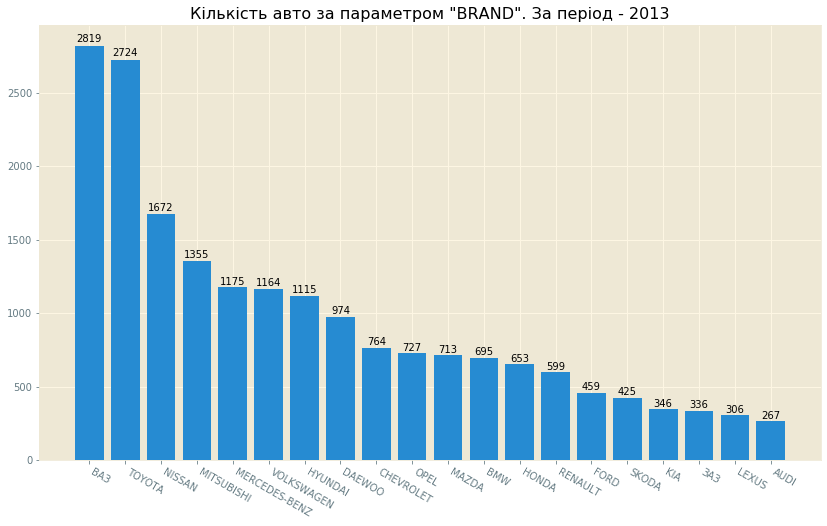

In [10]:
# Prepare data

params = ['Fuel', 'Brand', 'Model', 'Color']
p = params[1]
date = '2013'
UA_brands = ['ЗАЗ','DAEWOO','ЗАЗ-DAEWOO', 'ЛУАЗ']

df_all_new = df[df['Oper_code'] == 100]

data = df_all_new[(df_all_new.Kind == 'ЛЕГКОВИЙ') 
#                   & (df_new_cars.Brand.isin(UA_brands)) 
                  ]

# Stripe top 20
x_var = data[:date][p].value_counts()[:20].index
y_var = data[:date][p].value_counts()[:20].values


# Create plot
fig, ax = plt.subplots(figsize=(14,8))
rects = ax.bar(x=x_var, height=y_var)

#  Customize plot
ax.set(title='Кількість авто за параметром "' + str(p).upper() + '". За період - ' + date)
ax.set_xticklabels(labels=x_var, rotation=-30, ha='left')

# add labels for the bars
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,'%d' % int(height), ha='center', va='bottom')

plt.show()

In [ ]:
auto_brands = sorted(list(df[df.Kind == 'ЛЕГКОВИЙ']['Brand'].unique()))
print(auto_brands)

In [11]:
moskals = [
    'АЗЛК', 'АС', 'АСПЗ', 'АТ', 'БАЗ', 'ВАЗ', 'ВИС', 'ВС', 'ГАЗ', 
    'ГАЗ-ЧАЗ', 'ГАРЗ', 'ЕМ', 'ЕРАЗ', 'ЗИЛ', 'ЗИМ', 'ЗИС', 'ИЖ', 'КАВЗ', 'КАМА', 
    'КНОТТ', 'КРИПТОН-М', 'КТП', 'МАЗ', 'МЗМА', 'ОДАЗ', 'ОДИСЕЙ', 'ПГ', 'ПГМФ', 'ПР', 'ПСКОВ', 
    'РАФ', 'РОСАВТО'
]

respectful_brands = [
    'MAZDA',
    'RENAULT',
    'NISSAN',
    'VOLKSWAGEN',
    'TOYOTA',
#    'SKODA',
]

df_brands = [df_all_new[df_all_new['Brand'] == brand] for brand in respectful_brands]
df_moskal = df_all_new[df_all_new['Brand'].isin(moskals)]

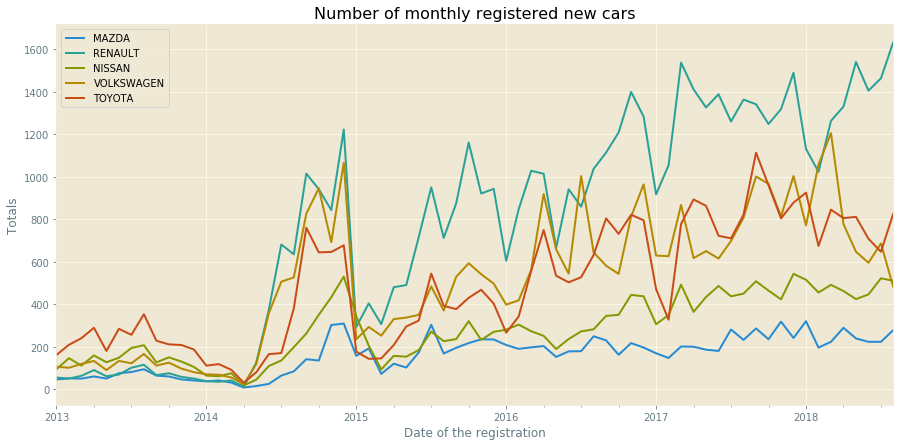

In [12]:
fig, ax1 = plt.subplots(figsize=(15,7))

for data in df_brands:
    data[:'2018-8'].resample('M').Person.count().plot(ax=ax1)

#df_moskal[:'2018'].resample('M').Person.count().plot(ax=ax1)


ax1.legend(respectful_brands 
#           + ['москалі']
          )
ax1.set(xlabel='Date of the registration', ylabel='Totals', title='Number of monthly registered new cars')

plt.show()

### Discovering trends

In [26]:
import statsmodels.api as sm

In [ ]:
brs = ['RENAULT']
df_brand_all = df[(df['Oper_code'] == 100) & (df['Brand'].isin(brs))][:'2018']

decomposed = sm.tsa.seasonal_decompose(df_brand_all.resample('M').Person.count(), 
                                       extrapolate_trend=1, 
                                       freq=12)

# Create plot
fig = plt.figure(figsize=(15,7))

# Plot and customize
ax = decomposed.trend.plot(label='Trend', linewidth=2)
ax = decomposed.observed.plot(label='Observed', linewidth=0.5)

ax.set(title='Trend for the number of registered new cars')
ax.legend()

plt.show()

### Compare UA market with world wide trends

Auto and Light Truck Sales Historical Chart [dataset](https://www.macrotrends.net/1372/auto-and-light-truck-sales-historical-chart) 

In [13]:
df_global_trends = pd.read_csv('./datasets/auto-and-light-truck-sales-historical-chart.csv', 
                               parse_dates=['date'], index_col='date', skiprows=15, skipinitialspace=True)

df_global_trends = df_global_trends['2013':'2018-8']

In [14]:
df_global_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2013-01-01 to 2018-08-01
Data columns (total 1 columns):
value    68 non-null float64
dtypes: float64(1)
memory usage: 1.1 KB


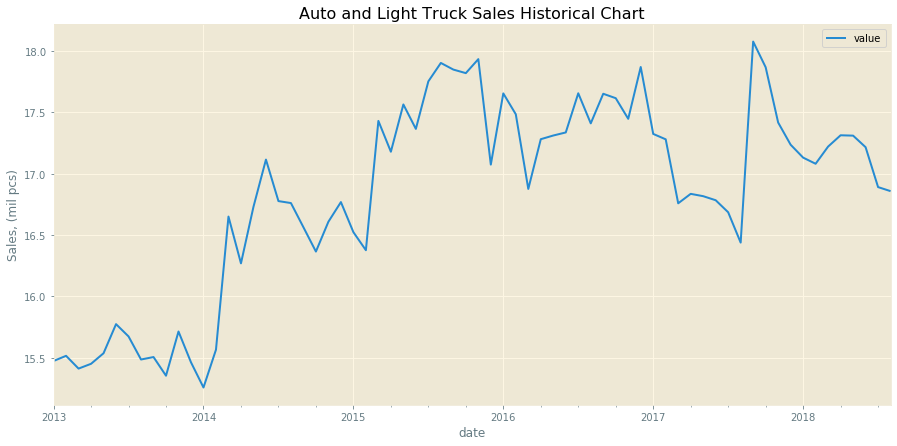

In [15]:
ax2 = df_global_trends.plot(figsize=(15,7))
ax2.set(ylabel='Sales, (mil pcs)', title='Auto and Light Truck Sales Historical Chart')

plt.show()

In [16]:
# Normalization function for global trends

f = lambda x: (x - df_global_trends.value.min())/(df_global_trends.value.max() - df_global_trends.value.min())

In [17]:
df_global_trends_norm = df_global_trends['value'].apply(f)

In [18]:
df_renault = df_all_new[(df_all_new['Brand'] == 'RENAULT') & (df_all_new['Kind'] == 'ЛЕГКОВИЙ')]['2013':'2018-8']

In [19]:
df_renault_sales_monhtly = df_renault['Person'].resample('M').count()

In [20]:
# Normalization function for UA market (Renault) sales

fn = lambda x: (x - df_renault_sales_monhtly.min())/(df_renault_sales_monhtly.max() - df_renault_sales_monhtly.min())

In [21]:
df_renault_sales_monhtly_norm = df_renault_sales_monhtly.apply(fn)

In [22]:
df_renault_sales_monhtly_norm.tail()

d_reg
2018-04-30    0.709961
2018-05-31    0.812500
2018-06-30    0.731445
2018-07-31    0.769531
2018-08-31    0.966797
Freq: M, Name: Person, dtype: float64

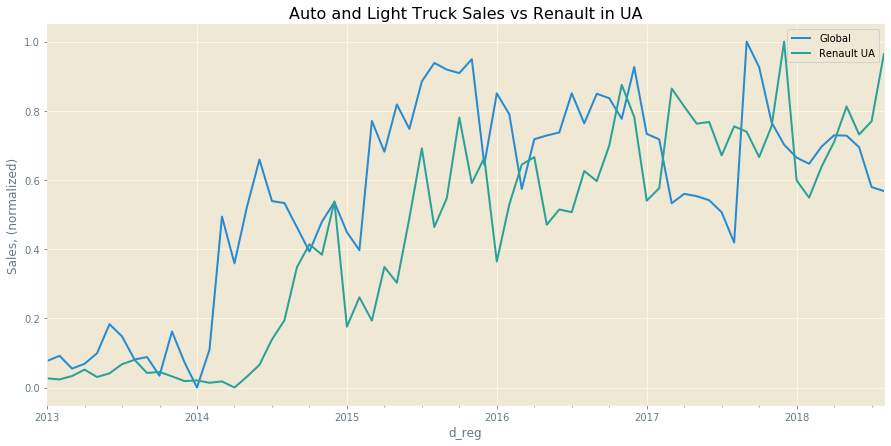

In [25]:
ax3 = df_global_trends_norm.plot(figsize=(15,7))
df_renault_sales_monhtly_norm.plot(ax=ax3)

ax3.set(ylabel='Sales, (normalized)', title='Auto and Light Truck Sales vs Renault in UA')
ax3.legend(['Global', 'Renault UA'])

plt.show()

### Disover and compare UA and global sales trends

In [38]:
window = 6 # Number in months

global_decomposed = sm.tsa.seasonal_decompose(df_global_trends_norm, 
                                       extrapolate_trend=1, 
                                       freq=window)

renault_decomposed = sm.tsa.seasonal_decompose(df_renault_sales_monhtly_norm, 
                                       extrapolate_trend=1, 
                                       freq=window)

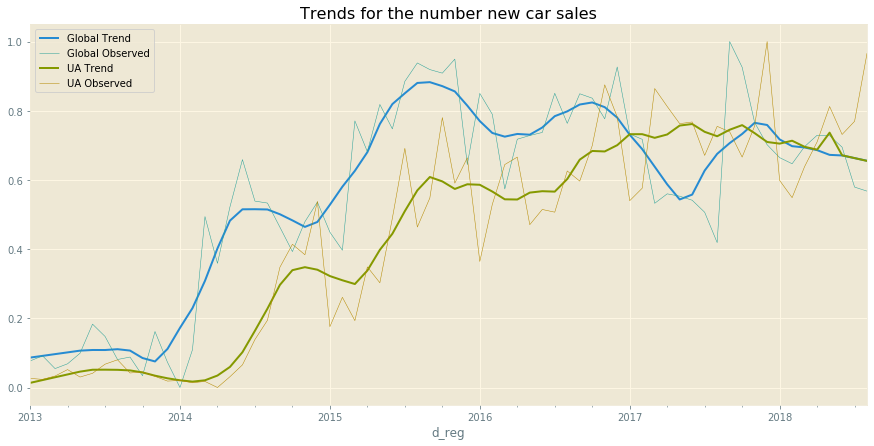

In [39]:
# Create plot
fig5 = plt.figure(figsize=(15,7))

# Plot and customize
ax5 = global_decomposed.trend.plot(label='Global Trend', linewidth=2)
global_decomposed.observed.plot(label='Global Observed', linewidth=0.5, ax=ax5)
renault_decomposed.trend.plot(label='UA Trend', linewidth=2, ax=ax5)
renault_decomposed.observed.plot(label='UA Observed', linewidth=0.5, ax=ax5)

ax5.set(title='Trends for the number new car sales')
ax5.legend()

plt.show()
